# 0. NOTES


FULL CODE EXAMPLE FOR A SIMPLE CHATBOT USING BOTH:
1) An Artificial Neural Network (ANN)
2) A Transformer-Based Model

This script demonstrates:
  - Environment setup (imports)
  - Data loading and preprocessing
   - ANN model training and inference
   - Transformer model training and inference
   - Performance comparison

# NOTE:
   - The code below is a unified example; in practice, you might split it into multiple files (e.g., data_preprocessing.py, models.py, train.py).
   - Adjust file paths, hyperparameters, and dataset loading as necessary.
   - Ensure the product_reviews.csv file has columns named "review" and "label".
   - Installing dependencies (outside of Python):
      pip install torch torchvision torchaudio
      pip install numpy pandas scikit-learn

Please note that for large or complex datasets, a more efficient approach (especially for the Transformer part) might be needed. 

# 1. ENVIRONMENT SETUP & IMPORTS

In [41]:
import torch
import traceback

# Default to CPU initially
device = torch.device("cpu")

try:
    # Try importing IPEX (Intel Extension for PyTorch)
    import intel_extension_for_pytorch as ipex

    # Check if xpu is supported and available
    if hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device("xpu")
        print(f"IPEX XPU is available. Device count: {torch.xpu.device_count()}")
        print(f"Using IPEX XPU device: {torch.xpu.get_device_name(0)}")

        # Test it with a small tensor
        test_tensor = torch.tensor([1., 2.], dtype=torch.float32).to(device)
        print(f"Successfully created tensor on device: {device}, Tensor: {test_tensor}")
    else:
        print("Intel XPU not available. Falling back to CPU.")
        if not hasattr(torch, 'xpu'):
            print("torch.xpu attribute not found. Make sure IPEX is correctly installed.")

except ImportError:
    print("IPEX is not installed. Running on CPU.")
except Exception as e:
    print("--------------------------------------------------")
    print("ERROR: IPEX or XPU device initialization failed.")
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {e}")
    traceback.print_exc()
    print("--------------------------------------------------")

print(f"Final selected device: {device}")


IPEX XPU is available. Device count: 1
Using IPEX XPU device: Intel(R) Arc(TM) A770 Graphics
Successfully created tensor on device: xpu, Tensor: tensor([1., 2.], device='xpu:0')
Final selected device: xpu


IMPORTING ALL THE OTHER IMPORTS NECESSARY

In [42]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize

device = torch.device("xpu" if torch.xpu.is_available() else "cpu")
print(f"Using device: {device}")


Using device: xpu


# 2. DATA LOADING & PREPROCESSING

In [43]:
# Adjust the path to your local product_reviews.csv file as needed.
CSV_PATH = r"amazon_cells_labelled.txt"

def preprocess_pandas(data, columns):
    df = pd.DataFrame(columns=columns)
    data['review'] = data['review'].str.lower()
    data['review'] = data['review'].replace(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)  # remove emails
    data['review'] = data['review'].replace(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)  # remove IP address
    data['review'] = data['review'].str.replace(r'[^\w\s]', '', regex=True)  # remove special characters
    data['review'] = data['review'].replace(r'\d', '', regex=True)  # remove numbers

    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['review'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df = df._append({
            "index": row['index'],
            "label": row['label'],
            "review": " ".join(filtered_sent)
        }, ignore_index=True)
    return df  # Return the processed DataFrame instead of the original

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv(CSV_PATH, delimiter='\t', header=None)
    data.columns = ['review', 'label']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'label', 'review']
    processed_data = preprocess_pandas(data, columns)                   # pre-process and get processed DataFrame
    
    # Split into train, validation, and test sets to match second code's structure
    train_data, test_data = train_test_split(
        processed_data,
        test_size=0.2,
        random_state=42
    )
    train_data, val_data = train_test_split(
        train_data,
        test_size=0.2,
        random_state=42
    )
    
    # Print the same output information as the second code
    print(f"Training samples: {len(train_data)}")
    print(f"Validation samples: {len(val_data)}")
    print(f"Test samples: {len(test_data)}")
    
    # The rest of your original processing can remain if needed
    training_texts = train_data['review'].values.astype('U')
    y_train = train_data['label'].values.astype('int32')
    validation_texts = val_data['review'].values.astype('U')
    y_val = val_data['label'].values.astype('int32')
    test_texts = test_data['review'].values.astype('U')
    y_test = test_data['label'].values.astype('int32')
    
    # Continue with vectorization if needed
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    X_train = vectorizer.fit_transform(training_texts)
    training_data_tfidf = X_train.todense()
    vocab_size = len(vectorizer.vocabulary_)
    X_val = vectorizer.transform(validation_texts)
    validation_data_tfidf = X_val.todense()
    X_test = vectorizer.transform(test_texts)
    test_data_tfidf = X_test.todense()
    

Training samples: 640
Validation samples: 160
Test samples: 200


# 3. TASK 1.1: ANN MODEL DEFINITION & TRAINING

Epoch [1/5], Train Loss: 0.0216, Val Loss: 0.6883, Train Acc: 0.4906, Val Acc: 0.4938
Epoch [2/5], Train Loss: 0.0209, Val Loss: 0.6709, Train Acc: 0.8000, Val Acc: 0.7562
Epoch [3/5], Train Loss: 0.0190, Val Loss: 0.6349, Train Acc: 0.9938, Val Acc: 0.7625
Epoch [4/5], Train Loss: 0.0157, Val Loss: 0.5858, Train Acc: 0.9969, Val Acc: 0.7625
Epoch [5/5], Train Loss: 0.0117, Val Loss: 0.5369, Train Acc: 0.9969, Val Acc: 0.7500


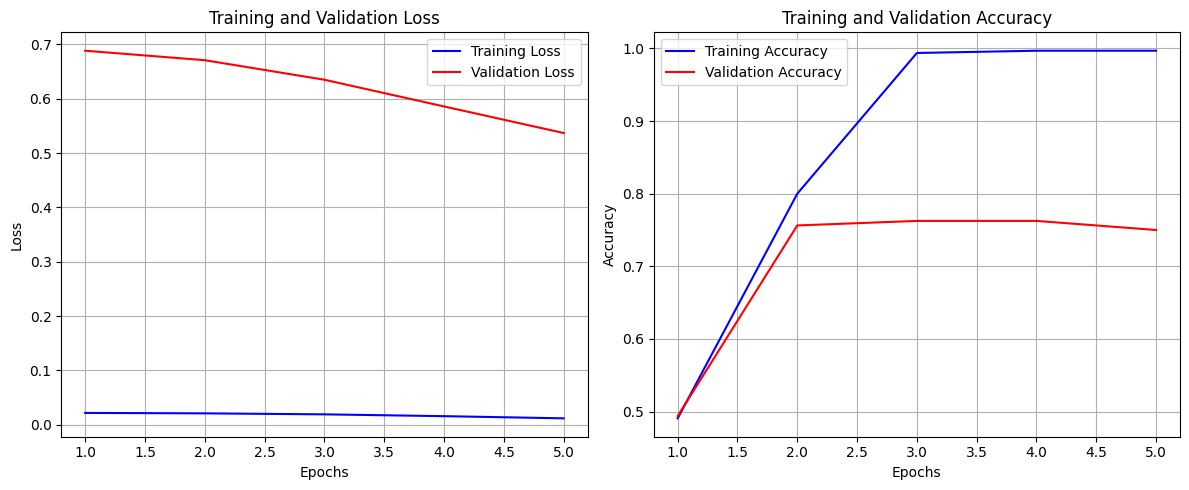

In [44]:
class SimpleANN(nn.Module):
    """
    A simple feed-forward ANN for binary classification (sentiment analysis).
    """
    def __init__(self, input_dim, hidden_dim=128, output_dim=1):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the ANN
input_dim = X_train.shape[1]  # Number of features from BOW
model_ann = SimpleANN(input_dim, hidden_dim=128, output_dim=1).to(device)
model_ann = model_ann.to(device)
criterion_ann = nn.BCELoss()  # Binary cross-entropy loss
optimizer_ann = optim.Adam(model_ann.parameters(), lr=0.001)

model_ann, optimizer_ann = ipex.optimize(model_ann, optimizer=optimizer_ann)

X_train_dense = X_train.toarray()
X_val_dense = X_val.toarray()

X_train_torch = torch.FloatTensor(X_train_dense).to(device)
y_train_torch = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_val_torch = torch.FloatTensor(X_val_dense).to(device)
y_val_torch = torch.FloatTensor(y_val).reshape(-1, 1).to(device)

def train_ann(model, criterion, optimizer, epochs=5, batch_size=32):
    """
    Trains the ANN model for a given number of epochs and batch size.
    Prints training and validation loss at each epoch.
    """

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i in range(0, len(X_train_torch), batch_size):
            x_batch = X_train_torch[i:i+batch_size]
            y_batch = y_train_torch[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        with torch.no_grad():
            val_outputs = model(X_val_torch)
            val_loss = criterion(val_outputs, y_val_torch)

            # Calculate validation accuracy
            val_predicted = (val_outputs > 0.5).float()
            correct_val = (val_predicted == y_val_torch).sum().item()
            val_acc = correct_val / len(X_val_torch)
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(val_loss.item())
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(val_acc)


        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {running_loss/len(X_train_torch):.4f}, "
              f"Val Loss: {val_loss.item():.4f}, "
              f"Train Acc: {epoch_train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    """
    Plots the training and validation loss and accuracy curves.
    """
    epochs_range = range(1, epochs + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs_range, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = train_ann(
    model_ann, criterion_ann, optimizer_ann, epochs=num_epochs, batch_size=32
)

# Plot the metrics
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)


def chatbot_response_ann(model, user_input):
    """
    Takes user input, vectorizes it using the same vectorizer,
    feeds it into the ANN model, and returns a sentiment response.
    """
    user_vec = vectorizer.transform([user_input]).toarray()
    user_tensor = torch.FloatTensor(user_vec).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(user_tensor)
    
    sentiment_positive = (output.item() > 0.5)
    if sentiment_positive:
        return "It sounds positive!"
    else:
        return "It seems negative."


### TESTING MULTIPLE SENTENCES ON THE CHATBOT:

In [45]:
num_runs = 5
for i in range(num_runs): 
    user_input_example = input("Type something for the ANN-based chatbot: ")
    print(f"You said: {user_input_example}")  # Print user input before response
    print(chatbot_response_ann(model_ann, user_input_example))  # Print chatbot response

You said: I am not trying this
It seems negative.
You said: You are very good at being bad
It sounds positive!
You said: You are not exactly bad
It seems negative.
You said: You are not very bad but also not good
It sounds positive!
You said: You are just well
It sounds positive!


# 4. TASK 1.2: TRANSFORMER MODEL DEFINITION & TRAINING

Training samples: 20
Validation samples: 5
Test samples: 7

Epoch [1/7], Train Loss: 0.9014, Val Loss: 0.6941, Train Acc: 0.5125, Val Acc: 0.5062
Epoch [2/7], Train Loss: 0.6910, Val Loss: 0.6901, Train Acc: 0.5094, Val Acc: 0.5062
Epoch [3/7], Train Loss: 0.6504, Val Loss: 0.6286, Train Acc: 0.5563, Val Acc: 0.6562
Epoch [4/7], Train Loss: 0.4091, Val Loss: 0.7952, Train Acc: 0.8594, Val Acc: 0.7000
Epoch [5/7], Train Loss: 0.1455, Val Loss: 1.0808, Train Acc: 0.9609, Val Acc: 0.7438
Epoch [6/7], Train Loss: 0.1261, Val Loss: 1.2521, Train Acc: 0.9734, Val Acc: 0.7438
Epoch [7/7], Train Loss: 0.0415, Val Loss: 1.7179, Train Acc: 0.9906, Val Acc: 0.7375


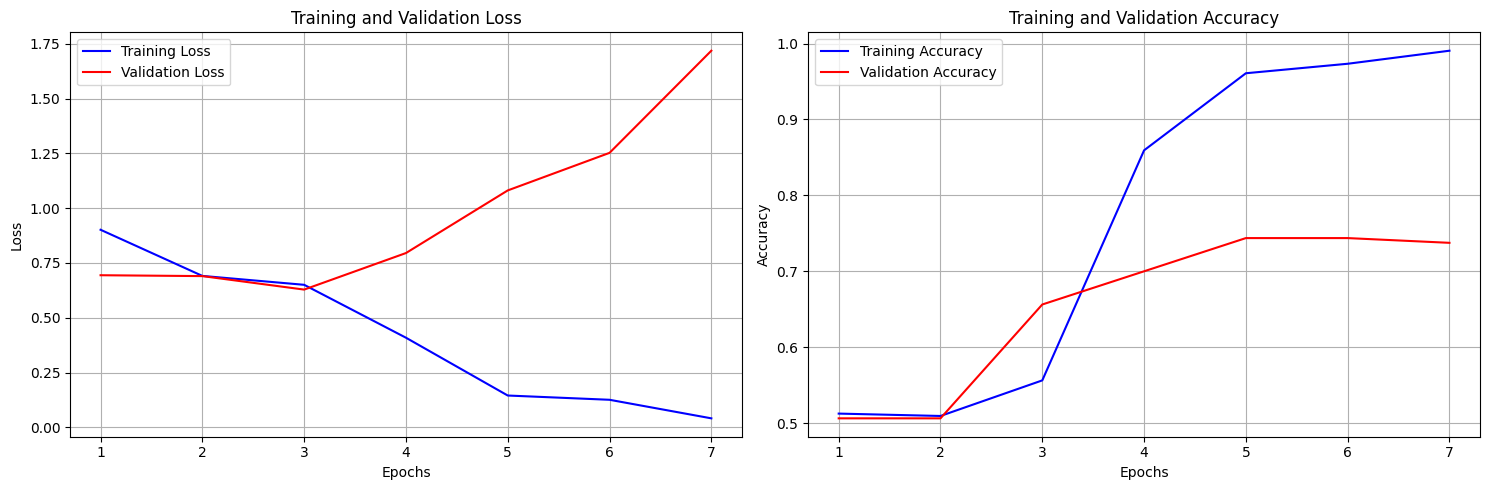

It sounds positive!


In [55]:
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer


class ReviewsDataset(Dataset):
    """
    Torch Dataset that takes in lists (or Series) of texts and labels
    along with the vectorizer to transform texts.
    """
    def __init__(self, texts, labels, vectorizer):
        # Reset index to ensure consistent indexing
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)  # Ensure labels have matching indices
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Debug: print index being fetched (remove in production)
        # print(f"Fetching index: {idx}")
        text = self.texts[idx]
        label = self.labels[idx]
        # Transform text to a dense vector
        text_vector = self.vectorizer.transform([text]).toarray()
        return torch.FloatTensor(text_vector), torch.FloatTensor([label])
    
# Reset indices in your data
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_dataset = ReviewsDataset(train_data['review'], train_data['label'], vectorizer)
val_dataset = ReviewsDataset(val_data['review'], val_data['label'], vectorizer)
test_dataset = ReviewsDataset(test_data['review'], test_data['label'], vectorizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(f"Training samples: {len(train_loader)}")
print(f"Validation samples: {len(val_loader)}")
print(f"Test samples: {len(test_loader)}\n")


class TransformerClassifier(nn.Module):
    """
    A basic Transformer-based model for binary classification.
    For simplicity, we:
      - Use a TransformerEncoder to process an entire BOW vector as if it were a single token.
      - Then pass the output to a linear layer -> sigmoid for classification.
    """
        
    def __init__(self, input_dim, nhead=4, num_layers=2, hidden_dim=128, dropout_prob=0.1):
        super(TransformerClassifier, self).__init__()

        # Adjust input_dim to be divisible by nhead
        if input_dim % nhead != 0:
            d_model = math.ceil(input_dim / nhead) * nhead
            print(f"⚠️ Adjusted input_dim from {input_dim} to {d_model} for nhead compatibility.")
        else:
            d_model = input_dim

        self.d_model = d_model

        self.encoder_layer = TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Classification head: first linear layer uses hidden_dim parameter
        self.fc1 = nn.Linear(self.d_model, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, src):
        # src shape: (batch_size, 1, original_dim)
        # Check if padding is needed
        original_dim = src.size(-1)

        if original_dim < self.d_model:
            pad_size = self.d_model - original_dim
            # Create padding tensor with zeros
            pad_tensor = torch.zeros(src.size(0), 1, pad_size, device=src.device, dtype=src.dtype)
            src = torch.cat((src, pad_tensor), dim=-1)

        elif original_dim > self.d_model:
            src = src[:, :, :self.d_model]
        
        # No need to transpose due to batch_first=True
        encoded = self.transformer_encoder(src)
        encoded_output = encoded[:, 0, :]  # Take first (and only) token
        
        # Classification head
        x = self.fc1(encoded_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        probs = self.sigmoid(x)
        return probs

# Fix input_dim before passing it into the model:
# Use X_train.shape[1] as the original dimension from TF-IDF. 
original_input_dim = X_train.shape[1]
adjusted_input_dim = math.ceil(original_input_dim / 4) * 4  # This is our target dimension.

model_transformer = TransformerClassifier(input_dim=adjusted_input_dim, nhead=4, num_layers=2, hidden_dim=128, dropout_prob=0.0)
model_transformer.to("xpu" if (hasattr(torch, "xpu") and torch.xpu.is_available()) else "cpu")

criterion_transformer = nn.BCELoss()
optimizer_transformer = optim.AdamW(model_transformer.parameters(), lr=0.001, weight_decay=0.01)
model_transformer, optimizer_transformer = ipex.optimize(model_transformer, optimizer=optimizer_transformer)



def train_transformer(model, criterion, optimizer, train_loader, val_loader, epochs):
    """
    Trains the Transformer model using the provided data loaders.
    Prints training and validation loss per epoch.
    """
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        
        for texts, labels in train_loader:
            texts, labels = texts.to(model.parameters().__next__().device), labels.to(model.parameters().__next__().device)
            
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Store predictions and true labels for accuracy calculation
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.detach().cpu().numpy())
            train_true.extend(labels.detach().cpu().numpy())

        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for val_texts, val_labels in val_loader:
                val_texts, val_labels = val_texts.to(model.parameters().__next__().device), val_labels.to(model.parameters().__next__().device)

                val_outputs = model(val_texts)
                val_loss += criterion(val_outputs, val_labels).item()

                # Store predictions and true labels for accuracy calculation
                preds = (val_outputs > 0.5).float()
                val_preds.extend(preds.detach().cpu().numpy())
                val_true.extend(val_labels.detach().cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = accuracy_score(np.array(train_true).flatten(), np.array(train_preds).flatten())
        val_accuracy = accuracy_score(np.array(val_true).flatten(), np.array(val_preds).flatten())

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, "
              f"Val Acc: {val_accuracy:.4f}")
        
    return train_losses, val_losses, train_accuracies, val_accuracies

epochs=7

# Train the model and collect metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_transformer(
    model_transformer, criterion_transformer, optimizer_transformer, train_loader, val_loader, epochs
)

# Plot the metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust layout and display plot
plt.tight_layout()
plt.show()


def chatbot_response_transformer(model, user_input):
    """
    Takes user input, vectorizes it using the same BOW vectorizer,
    feeds it into the Transformer model, and returns a sentiment response.
    """
    user_vec = vectorizer.transform([user_input]).toarray()
    user_tensor = torch.FloatTensor(user_vec).unsqueeze(1)  # Shape: (1, 1, input_dim)

    # Move the tensor to the same device as the model
    user_tensor = user_tensor.to(next(model.parameters()).device)

    # Ensure the tensor is properly padded or truncated to match model.d_model
    if hasattr(model, "d_model"):
        if user_tensor.size(-1) < model.d_model:
            pad_size = model.d_model - user_tensor.size(-1)
            pad_tensor = torch.zeros(user_tensor.size(0), user_tensor.size(1), pad_size,
                                       device=user_tensor.device, dtype=user_tensor.dtype)
            user_tensor = torch.cat((user_tensor, pad_tensor), dim=-1)
        elif user_tensor.size(-1) > model.d_model:
            user_tensor = user_tensor[:, :, :model.d_model]

    model.eval()
    with torch.no_grad():
        output = model(user_tensor)

    sentiment_positive = (output.item() > 0.5)
    return "It sounds positive!" if sentiment_positive else "It seems negative."

# Example usage:
user_input_example = input("Type something for the Transformer-based chatbot: ")
print(chatbot_response_transformer(model_transformer, user_input_example))

### TESTING THE TRANSFORMER ON A FEW SENTENCES AS DONE WITH THE ANN PREVIOUSLY:

In [56]:
num_runs = 5
for i in range(num_runs): 
    user_input_example = input("Type something for the ANN-based chatbot: ")
    print(f"You said: {user_input_example}")  # Print user input before response
    print(chatbot_response_transformer(model_transformer, user_input_example))  # Print chatbot response

You said: You are very good
It sounds positive!
You said: You are not not good
It sounds positive!
You said: You just like to insult
It seems negative.
You said: You are also delusional
It sounds positive!
You said: You are very bad
It seems negative.


# 6. TASK 1.3: MODEL COMPARISON

Confusion matrix for  ANN  model:


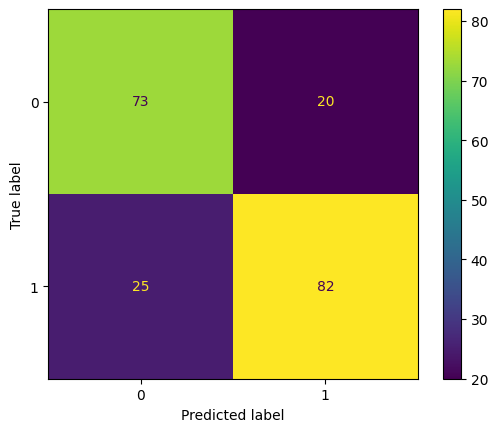

recall =  0.7663551401869159
precision =  0.803921568627451
F1-score   = 0.7847

Confusion matrix for  Transformer  model:


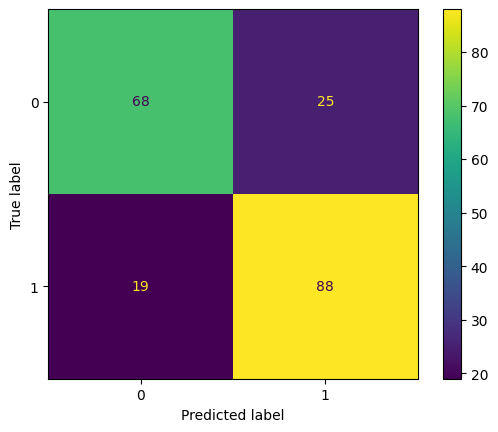

recall =  0.822429906542056
precision =  0.7787610619469026
F1-score   = 0.8000


FINAL TEST ACCURACIES
ANN Test Accuracy: 0.7750
Transformer Test Accuracy: 0.7800


In [57]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, X_data, y_data):
    """
    Evaluates the ANN model on a dataset represented by X_data (NumPy array)
    and y_data (NumPy array of labels). Returns accuracy.
    """
    model.eval()
    model.to(device)  # Move model to GPU if available

    # Convert sparse matrix to dense if needed
    if hasattr(X_data, "toarray"):
        X_data = X_data.toarray()

    X_torch = torch.FloatTensor(X_data).to(device)
    with torch.no_grad():
        outputs = model(X_torch)

    preds = (outputs.detach().cpu().numpy() > 0.5).astype(int)
    accuracy = accuracy_score(y_data, preds)
    
    confusion_matrix_and_values(y_data, preds, "ANN")
    return accuracy


def evaluate_model_transformer(model, data_loader):
    """
    Evaluates the Transformer model using a DataLoader.
    Returns accuracy on that dataset.
    """
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            preds = (outputs > 0.5).float().detach().cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.detach().cpu().numpy().flatten())

    all_preds = [int(p > 0.5) for p in all_preds]  # Make sure these are 0 or 1
    all_labels = [int(l) for l in all_labels]
    
    confusion_matrix_and_values(all_labels, all_preds, "Transformer")
    return accuracy_score(all_labels, all_preds)


def confusion_matrix_and_values(labels, predictions, modelname):
    print("Confusion matrix for ", modelname, " model:")
    T_N = 0
    T_P = 0
    F_N = 0
    F_P = 0
    i = 0
    
    for i, label in enumerate(labels):
        pred = predictions[i]
        if label == pred:
            if label == 1:
                T_P += 1
            else:
                T_N += 1
        elif label == 1 and pred == 0:
            F_N += 1
        else:
            F_P += 1

    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    precision = T_P / (T_P + F_P) if (T_P + F_P) > 0 else 0
    recall = T_P / (T_P + F_N) if (T_P + F_N) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print("recall = ", recall)
    print("precision = ", precision)
    print(f"F1-score   = {f1_score:.4f}\n")
    
# ANN test accuracy
ann_test_accuracy = evaluate_model(model_ann, X_test, y_test)

# Transformer test accuracy
transformer_test_accuracy = evaluate_model_transformer(model_transformer, test_loader)

print("\n======================")
print("FINAL TEST ACCURACIES")
print("======================")
print(f"ANN Test Accuracy: {ann_test_accuracy:.4f}")
print(f"Transformer Test Accuracy: {transformer_test_accuracy:.4f}")
print("======================")    